<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<H3 align='center'>  Jorge Portilla / John Rodriguez </H3>

<hr style="height:2px;border:none"/>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.callbacks import Callback
%matplotlib inline

Using TensorFlow backend.


## Pregunta 1

**a) Construya un dataframe con los datos a analizar y descríbalo brevemete. Además, realice la división de éste en los conjuntos de entrenamiento, validación y testeo correspondientes. Comente por qué se deben eliminar ciertas columnas**

In [2]:
df = pd.read_csv("EnergyMolecule/roboBohr.csv")
df.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total = len(df)

print(df.shape)
print(df.info())

dfTrain = df[:int(0.6*total)]
dfVal = df[int(0.6*total):int(0.85*total)]    
dfTest = df[int(0.85*total)::]

(16242, 1276)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Columns: 1276 entries, 0 to Eat
dtypes: float64(1276)
memory usage: 158.1 MB
None


Los datos corresponden a un csv compuesto de 1276 columnas correspondientes a las variables, y 16242 filas que corresponden a las diferentes simulaciones.

Las columnas 'Unnamed: 0' y 'pubchem_id' se eliminan por no tener datos relevante para los conjuntos de entrenamiento, validación y testeo. 'Unnamed: 0' no es necesaria debido a que corresponde a una enumeración, y el dataframe de panda ya viene con una incluída. 'pubchem_id' no es necesaria tampoco pues corresponde a la ID de la simulación.

**a.1) Una buena práctica es la de normalizar los datos antes de trabajar con el modelo. Explique por qué se aconseja dicho preprocesamiento**

Para un mejor funcionamiento de los algoritmos de Machine learning, hay que normalizar las variables de entrada del algoritmo, Normalizar, hace referencia a extender o comprimir los valores de una variable para estar en un rango definido. Es decir, realiza una ponderación de las caracterisiticas de una mejor manera y ademas se reduce el facor de escala. Sin embargo, realizar una mala eleccion del metodo de normalización puede alterar los resultados del analisis de datos. En este caso, se realiza una estandarización de los datos, debido a que si usamos normalización los outlayers podrían causar un desbalance de los datos en el intervalo, haciendo que muchos de ellos se agrupen cerca del 0.0 y que el outlayer quede como -1 o 1.


In [3]:
#Pre-processing#

#x var's
xTrain = pd.DataFrame.copy(dfTrain)
xVal = pd.DataFrame.copy(dfVal)
xTest = pd.DataFrame.copy(dfTest)

#y var's
yTrain = xTrain.pop('Eat').values.reshape(-1, 1)
yVal = xVal.pop('Eat').values.reshape(-1, 1)
yTest = xTest.pop('Eat').values.reshape(-1, 1)

#Scaler
scaler = StandardScaler().fit(xTrain)

#All standarized
xTrainScaled = pd.DataFrame(scaler.transform(xTrain),columns=xTrain.columns)
xValScaled = pd.DataFrame(scaler.transform(xVal),columns=xVal.columns)
xTestScaled = pd.DataFrame(scaler.transform(xTest),columns=xTest.columns)

In [4]:
print (xTrainScaled)

             0         1         2         3         4         5         6  \
0    -0.351225 -0.509371 -1.033927 -0.919025 -0.816522 -0.768547 -0.658326   
1    -0.351225 -0.173570 -0.217847 -0.065078  0.166757  0.531135  0.733115   
2    -0.351225 -0.507875 -1.028174 -0.927411 -0.827401 -0.781912 -0.686210   
3    -0.351225 -0.502487 -0.306285 -0.069657  0.160048  0.526034 -0.626222   
4    -0.351225 -0.501537 -0.306690 -0.069371  0.154188 -0.753856 -0.643575   
5    -0.534463 -0.601755 -0.426150 -0.336046 -0.150006  0.095425  0.184027   
6    -0.534463 -0.601506 -0.426888 -0.335822 -0.151045  0.100177  0.217377   
7    -0.534463 -0.820937 -0.674957 -0.507226 -0.587258 -0.463539 -0.340389   
8    -0.351225 -0.173628 -0.213560 -0.099212 -0.147283 -0.332590 -0.341743   
9    -0.351225 -0.539546 -0.347864 -0.888295 -0.800924 -0.746548 -0.631686   
10   -0.351225 -0.417330 -0.302129 -0.080777  0.134428  0.480288  0.660479   
11   -0.351225 -0.500410 -0.303433 -0.065110  0.157177  0.513242

**b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.**

Se crea un la red feedward de 3 capas como se especifica, para luego graficar el error obtenido en el entrenamiento y en las pruebas.

In [6]:
numEpochs = 250
test_loss = np.zeros(numEpochs)

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss = self.model.evaluate(x, y, verbose=0)
        test_loss[epoch-1] = loss
        print('\nTesting loss: {}'.format(loss))

In [7]:
model = Sequential()
model.add(Dense(256, input_dim=xTrainScaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear"))
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error') #, metrics=['accuracy']

history = model.fit(xTrainScaled.values,
                    yTrain,
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=(xValScaled.values, yVal), 
                    callbacks=[TestCallback((xTestScaled.values, yTest))])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 595us/step - loss: 1.4672 - val_loss: 0.5401

Testing loss: 0.5403369542487978
Epoch 2/250
9745/9745 [==============================] - 5s 524us/step - loss: 0.5976 - val_loss: 0.4224

Testing loss: 0.43395390870583855
Epoch 3/250
9745/9745 [==============================] - 4s 411us/step - loss: 0.4991 - val_loss: 0.3749

Testing loss: 0.36610294188149994
Epoch 4/250
9745/9745 [==============================] - 5s 466us/step - loss: 0.4307 - val_loss: 0.3376

Testing loss: 0.29767803466853227
Epoch 5/250
9745/9745 [==============================] - 5s 495us/step - loss: 0.3701 - val_loss: 0.3137

Testing loss: 0.3105650534383283
Epoch 6/250
9745/9745 [==============================] - 5s 509us/step - loss: 0.3253 - val_loss: 0.3114

Testing loss: 0.28619824877565986
Epoch 7/250
9745/9745 [==============================] - 4s 443us/step - loss: 0.2876 - val_loss: 0.2367

Testing 

9745/9745 [==============================] - 6s 613us/step - loss: 0.0383 - val_loss: 0.0538

Testing loss: 0.03516501024561091
Epoch 60/250
9745/9745 [==============================] - 6s 594us/step - loss: 0.0369 - val_loss: 0.0777

Testing loss: 0.06342758265219607
Epoch 61/250
9745/9745 [==============================] - 6s 646us/step - loss: 0.0359 - val_loss: 0.0532

Testing loss: 0.033830316259594886
Epoch 62/250
9745/9745 [==============================] - 6s 615us/step - loss: 0.0367 - val_loss: 0.0577

Testing loss: 0.04013192400513588
Epoch 63/250
9745/9745 [==============================] - 6s 619us/step - loss: 0.0352 - val_loss: 0.0578

Testing loss: 0.03499583894471727
Epoch 64/250
9745/9745 [==============================] - 6s 619us/step - loss: 0.0358 - val_loss: 0.0562

Testing loss: 0.03805285289953931
Epoch 65/250
9745/9745 [==============================] - 6s 590us/step - loss: 0.0344 - val_loss: 0.0625

Testing loss: 0.05168792128159367
Epoch 66/250
9745/9745 [=

9745/9745 [==============================] - 6s 645us/step - loss: 0.0240 - val_loss: 0.0545

Testing loss: 0.03586136741880106
Epoch 118/250
9745/9745 [==============================] - 7s 684us/step - loss: 0.0238 - val_loss: 0.0470

Testing loss: 0.03613861489797964
Epoch 119/250
9745/9745 [==============================] - 6s 586us/step - loss: 0.0229 - val_loss: 0.0749

Testing loss: 0.05436815892850272
Epoch 120/250
9745/9745 [==============================] - 6s 567us/step - loss: 0.0239 - val_loss: 0.0416

Testing loss: 0.028452531847709947
Epoch 121/250
9745/9745 [==============================] - 6s 630us/step - loss: 0.0230 - val_loss: 0.0456

Testing loss: 0.02886229314201977
Epoch 122/250
9745/9745 [==============================] - 6s 624us/step - loss: 0.0232 - val_loss: 0.0414

Testing loss: 0.026804336322992
Epoch 123/250
9745/9745 [==============================] - 7s 681us/step - loss: 0.0228 - val_loss: 0.0452

Testing loss: 0.029045698187471807
Epoch 124/250
9745/9


Testing loss: 0.03176446444560171
Epoch 175/250
9745/9745 [==============================] - 4s 386us/step - loss: 0.0179 - val_loss: 0.0383

Testing loss: 0.028840510595007467
Epoch 176/250
9745/9745 [==============================] - 4s 433us/step - loss: 0.0182 - val_loss: 0.0383

Testing loss: 0.028148422139220225
Epoch 177/250
9745/9745 [==============================] - 4s 428us/step - loss: 0.0178 - val_loss: 0.0387

Testing loss: 0.024860669543472137
Epoch 178/250
9745/9745 [==============================] - 4s 448us/step - loss: 0.0175 - val_loss: 0.0437

Testing loss: 0.02673505353796761
Epoch 179/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.0178 - val_loss: 0.0403

Testing loss: 0.02500036320770232
Epoch 180/250
9745/9745 [==============================] - 5s 463us/step - loss: 0.0179 - val_loss: 0.0469

Testing loss: 0.0333820864004853
Epoch 181/250
9745/9745 [==============================] - 4s 442us/step - loss: 0.0171 - val_loss: 0.0420

Tes

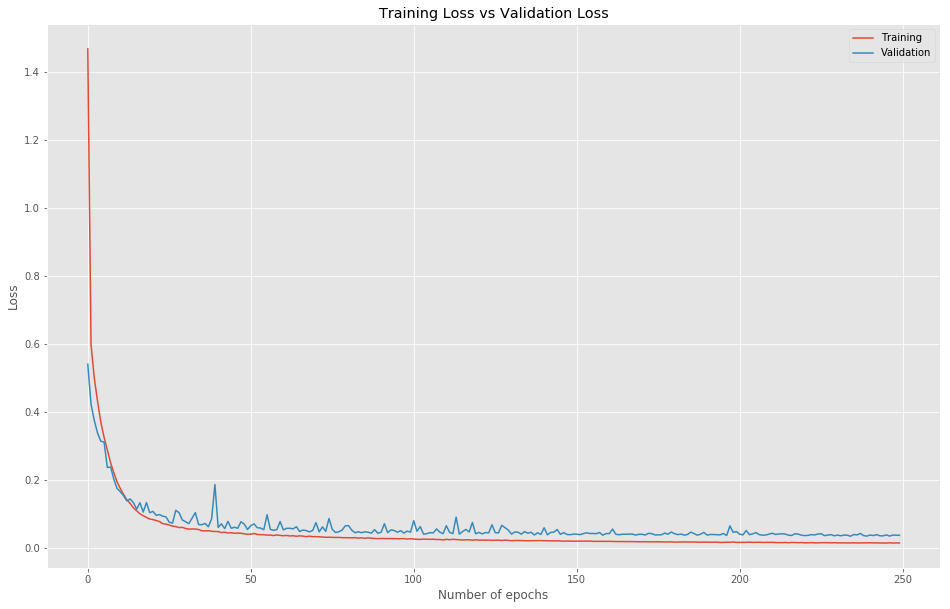

In [11]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
xc = range(numEpochs)
plt.figure(1, figsize=(16, 10))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss vs Validation Loss')
plt.grid(True)
plt.legend(['Training', 'Validation'])
#print(plt.style.available)
plt.style.use(['ggplot'])

El gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de epochs de entrenamiento, para una red feedforward de 3 capas, con 256 unidades ocultas y **función de activación sigmoidal**. Entrenada la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación.

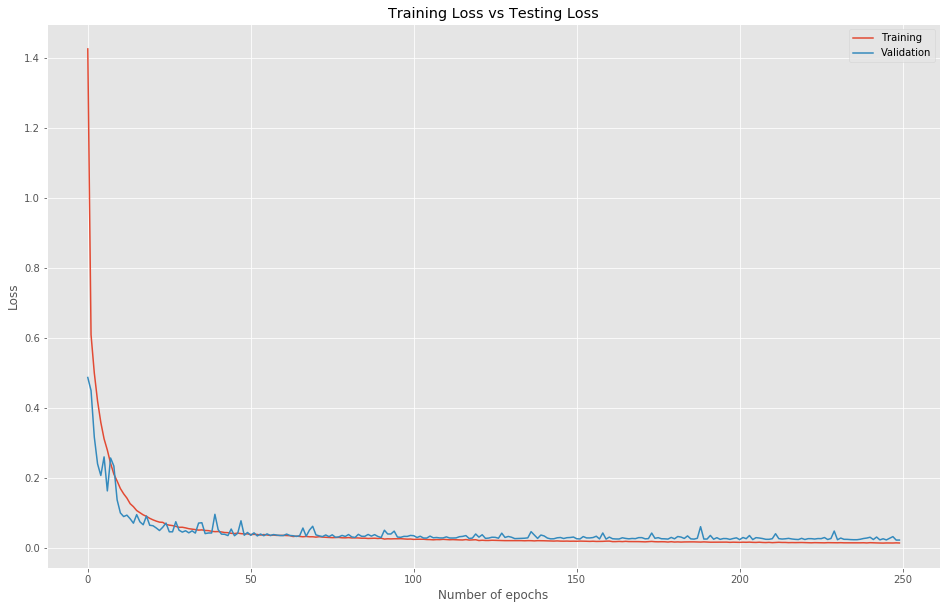

In [17]:
#El último valor del testing siempre venía erroneo, por lo que se reemplaza con el correcto
#evaluando el modelo con 250 epochs (modelo final)
test_loss[-1] = model.evaluate(xTestScaled.values, yTest, verbose=0)
train_loss=history.history['loss']
xc = range(numEpochs)
plt.figure(1, figsize=(16, 10))
plt.plot(xc,train_loss)
plt.plot(xc,test_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss vs Testing Loss')
plt.grid(True)
plt.legend(['Training', 'Validation'])
#print(plt.style.available)
plt.style.use(['ggplot'])

Usando la función de activación sigmoidal, podemos ver que el error va decreciendo a medida que se aumenta el número de epochs. Por lo tanto este metodo converge



**Faltan comentarios sobre DIVERGENCIA !!!**

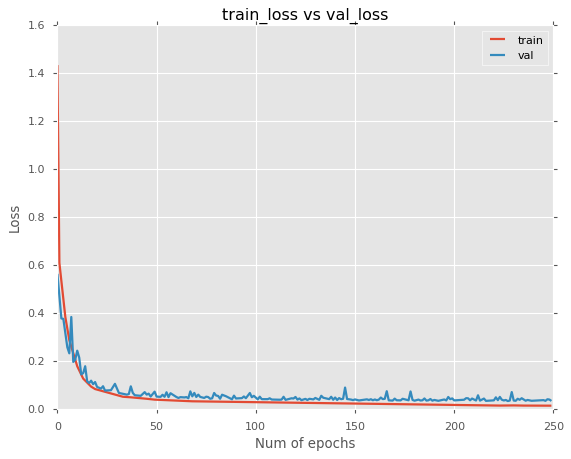

**c) Repita el paso anterior, utilizado ’ReLU’ como función de activación y compare con lo obtenido en b). **

In [18]:
model2 = Sequential()
model2.add(Dense(256, input_dim=xTrainScaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model2.add(Dense(1, kernel_initializer='uniform',activation="relu"))
model2.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error') #, metrics=['accuracy']

history = model2.fit(xTrainScaled.values,
                    yTrain,
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=(xValScaled.values, yVal), 
                    callbacks=[TestCallback((xTestScaled.values, yTest))])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 10s 1ms/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 2/250
9745/9745 [==============================] - 10s 999us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 3/250
9745/9745 [==============================] - 9s 956us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 4/250
9745/9745 [==============================] - 10s 1ms/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 5/250
9745/9745 [==============================] - 11s 1ms/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 6/250
9745/9745 [==============================] - 12s 1ms/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 7/250
9745/9745 [==============================] - 10s 1ms/step - loss: 135.6843 - val_loss

9745/9745 [==============================] - 4s 378us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 59/250
9745/9745 [==============================] - 4s 380us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 60/250
9745/9745 [==============================] - 4s 407us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 61/250
9745/9745 [==============================] - 4s 400us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 62/250
9745/9745 [==============================] - 3s 336us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 63/250
9745/9745 [==============================] - 4s 378us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 64/250
9745/9745 [==============================] - 4s 360us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch

9745/9745 [==============================] - 4s 399us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 116/250
9745/9745 [==============================] - 3s 355us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 117/250
9745/9745 [==============================] - 3s 349us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 118/250
9745/9745 [==============================] - 4s 395us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 119/250
9745/9745 [==============================] - 4s 381us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 120/250
9745/9745 [==============================] - 4s 373us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 121/250
9745/9745 [==============================] - 4s 444us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515


Testing loss: 120.96336867528515
Epoch 172/250
9745/9745 [==============================] - 3s 332us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 173/250
9745/9745 [==============================] - 3s 330us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 174/250
9745/9745 [==============================] - 4s 385us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 175/250
9745/9745 [==============================] - 4s 405us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 176/250
9745/9745 [==============================] - 4s 424us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 177/250
9745/9745 [==============================] - 4s 409us/step - loss: 135.6843 - val_loss: 155.2158

Testing loss: 120.96336867528515
Epoch 178/250
9745/9745 [==============================] - 4s 417us/step - loss: 135.6843 - val_

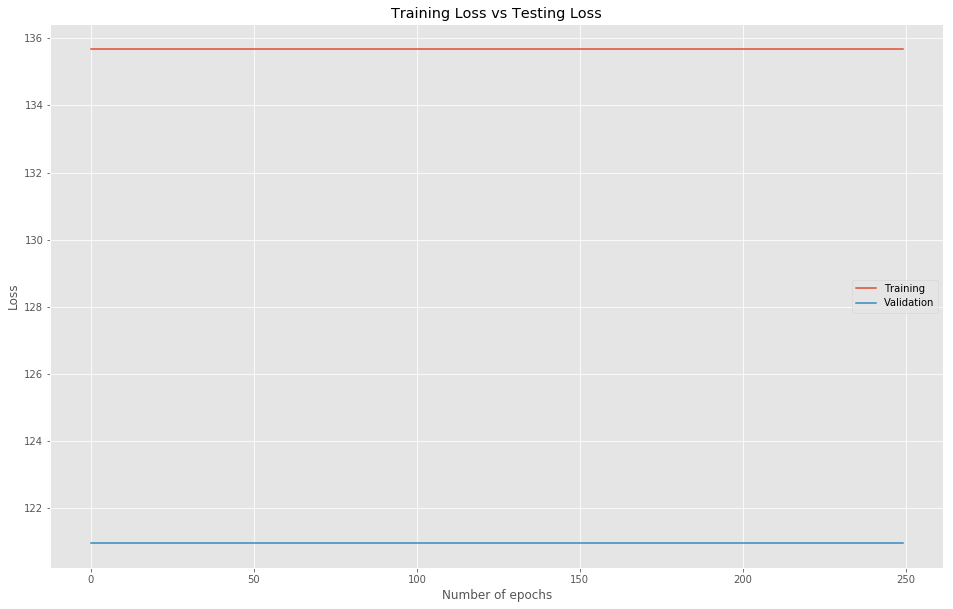

In [19]:
test_loss[-1] = model2.evaluate(xTestScaled.values, yTest, verbose=0)
train_loss = history.history['loss']
xc = range(numEpochs)
plt.figure(1, figsize=(16, 10))
plt.plot(xc,train_loss)
plt.plot(xc,test_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss vs Testing Loss')
plt.grid(True)
plt.legend(['Training', 'Validation'])
#print(plt.style.available)
plt.style.use(['ggplot'])

> c) Repita el paso anterior, utilizado ’**ReLU**’ como función de activación y compare con lo obtenido en b).  

```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
#%%El gráfico el error cuadrático (MSE) 
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
xc = range(250)
plt.figure(1, figsize=(8,6))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.ylabel('Loss')
plt.xlabel('Num of epochs')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
#print (plt.style.available)
plt.style.use(['ggplot'])
#%%
```

>El gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de epochs de entrenamiento, para una red feedforward de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrenada la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación.

>**Faltan comentarios!!!**
>Modificando solo esas lineas,este codigo:
```python
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
```
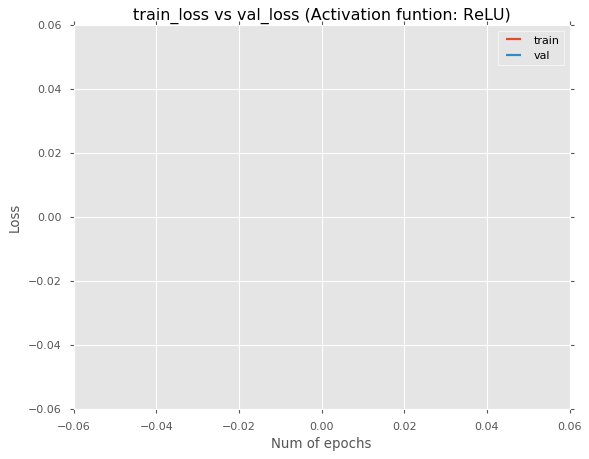


>Con este codigo:
```python
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="relu")) 
```
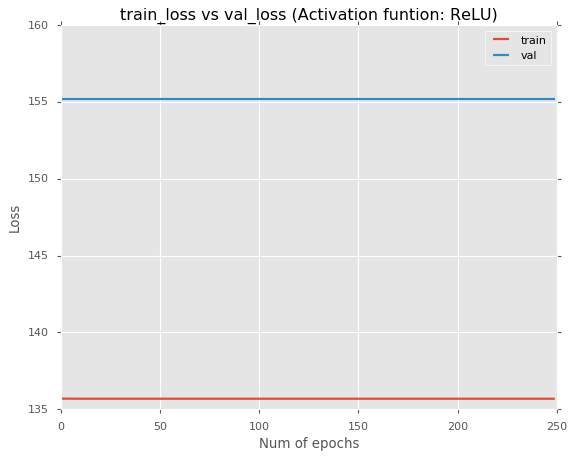

**d) Repita b) y c) variando la tasa de aprendizaje (*learning rate*) en un rango sensible. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.**


Se observa en el entrenamiento variando el learning rate en rangos sensibles, que con valores grandes se produce divergencia. Esto porque con valores muy grandes la optimizacion se hace inestable rebotando alrededor del optimo, los cambios en los pesos pueden ser tan grandes que sobrepasan el minimo y empeoran la perdida en vez de mejorar.
En el caso que el valor sea demasiado pequeño, la optimizacion debera ejecutarse demasiadas veces sin garantizar que encuentre un optimo ademas de tardar mucho tiempo.  Por lo que se recomienda utilizar diferente valores, con el fin de obtener la mejor perdida sin sacrificar la velocidad de entrenamiento. Cunado se entrena con un learning rate pequeño, en algun punto el valor de la funcion de perdida empezara a disminuir en la primeras iteraciones. Este learning rate es el maximo que se debe usar, cualquier otro valor por encima de este hara que el entrenamiento no converga.


In [8]:
def iterateOverLearningRate(n_lr, activ):
    lear_rate = np.linspace(0,1,n_lr)
    histories = np.ndarray((20, ), object)

    for i in range (n_lr):
        model = Sequential()
        model.add(Dense(256, input_dim=xTrainScaled.shape[1], kernel_initializer='uniform',activation=activ))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear"))
        model.compile(optimizer=SGD(lear_rate[i]),loss='mean_squared_error')
        histories[i] = model.fit(xTrainScaled.values,
                        yTrain,
                        epochs=250,
                        verbose=1,
                        validation_data=(xValScaled.values, yVal), 
                        callbacks=[TestCallback((xTestScaled.values, yTest))])
    return histories

In [11]:
histories = iterateOverLearningRate(20, "sigmoid")

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 5s 470us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 2/250
9745/9745 [==============================] - 4s 428us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 3/250
9745/9745 [==============================] - 4s 360us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 4/250
9745/9745 [==============================] - 4s 381us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 5/250
9745/9745 [==============================] - 4s 376us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 6/250
9745/9745 [==============================] - 5s 521us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 7/250
9745/9745 [==============================] - 10s 1ms/step - loss: 134.3590 - val_l

9745/9745 [==============================] - 12s 1ms/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 59/250
9745/9745 [==============================] - 11s 1ms/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 60/250
9745/9745 [==============================] - 12s 1ms/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 61/250
9745/9745 [==============================] - 11s 1ms/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 62/250
9745/9745 [==============================] - 11s 1ms/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 63/250
9745/9745 [==============================] - 11s 1ms/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 64/250
9745/9745 [==============================] - 11s 1ms/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 65/250


Testing loss: 119.67663852220487
Epoch 172/250
9745/9745 [==============================] - 7s 740us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 173/250
9745/9745 [==============================] - 8s 832us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 174/250
9745/9745 [==============================] - 7s 767us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 175/250
9745/9745 [==============================] - 8s 831us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 176/250
9745/9745 [==============================] - 8s 852us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 177/250
9745/9745 [==============================] - 7s 712us/step - loss: 134.3590 - val_loss: 153.7227

Testing loss: 119.67663852220487
Epoch 178/250
9745/9745 [==============================] - 8s 805us/step - loss: 134.3590 - val_

9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 43/250
9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 44/250
9745/9745 [==============================] - 14s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 45/250
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 46/250
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 47/250
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 48/250
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 49/250
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 50/250
9745/9745 [==============================] - 11s 1ms/ste

9745/9745 [==============================] - 3s 354us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 180/250
9745/9745 [==============================] - 4s 361us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 181/250
9745/9745 [==============================] - 4s 403us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 182/250
9745/9745 [==============================] - 3s 351us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 183/250
9745/9745 [==============================] - 3s 325us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 184/250
9745/9745 [==============================] - 3s 322us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 185/250
9745/9745 [==============================] - 3s 320us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 186/250
9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 187/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 375us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 66/250
9745/9745 [==============================] - 4s 399us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 67/250
9745/9745 [==============================] - 3s 341us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 68/250
9745/9745 [==============================] - 4s 362us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 69/250
9745/9745 [==============================] - 4s 364us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 70/250
9745/9745 [==============================] - 4s 373us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 71/250
9745/9745 [==============================] - 4s 422us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 72/250
9745/9745 [==============================] - 5s 475us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 73/250
9745/9745 [==============================] - 5s 


Testing loss: nan
Epoch 134/250
9745/9745 [==============================] - 4s 373us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 135/250
9745/9745 [==============================] - 4s 397us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 136/250
9745/9745 [==============================] - 4s 361us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 137/250
9745/9745 [==============================] - 4s 441us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 138/250
9745/9745 [==============================] - 4s 370us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 139/250
9745/9745 [==============================] - 4s 398us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 140/250
9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 141/250
9745/9745 [==============================] - 4s 366us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 142/250
9745/97

9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 203/250
9745/9745 [==============================] - 4s 437us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 204/250
9745/9745 [==============================] - 3s 349us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 205/250
9745/9745 [==============================] - 4s 384us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 206/250
9745/9745 [==============================] - 4s 374us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 3s 351us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 4s 367us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 3s 321us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [=============================

9745/9745 [==============================] - 3s 317us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 90/250
9745/9745 [==============================] - 3s 324us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 91/250
9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 92/250
9745/9745 [==============================] - 3s 335us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 93/250
9745/9745 [==============================] - 3s 319us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 4s 369us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 3s 321us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 3s 318us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 3s 

9745/9745 [==============================] - 4s 376us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 226/250
9745/9745 [==============================] - 4s 428us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 227/250
9745/9745 [==============================] - 4s 428us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 228/250
9745/9745 [==============================] - 4s 388us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 229/250
9745/9745 [==============================] - 4s 395us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 5s 521us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 6s 587us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 4s 451us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [=============================

9745/9745 [==============================] - 5s 469us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 113/250
9745/9745 [==============================] - 5s 488us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 114/250
9745/9745 [==============================] - 5s 501us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 5s 501us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 5s 512us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 5s 470us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 5s 474us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 5s 486us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [=============================

9745/9745 [==============================] - 5s 494us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 249/250
9745/9745 [==============================] - 5s 529us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 250/250
9745/9745 [==============================] - 5s 519us/step - loss: nan - val_loss: nan

Testing loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 5s 530us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/250
9745/9745 [==============================] - 5s 462us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/250
9745/9745 [==============================] - 5s 500us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 5s 516us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 5s 466us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745


Testing loss: nan
Epoch 135/250
9745/9745 [==============================] - 5s 543us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 136/250
9745/9745 [==============================] - 5s 523us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 137/250
9745/9745 [==============================] - 5s 557us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 138/250
9745/9745 [==============================] - 5s 549us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 139/250
9745/9745 [==============================] - 5s 561us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 140/250
9745/9745 [==============================] - 5s 531us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 141/250
9745/9745 [==============================] - 4s 447us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 142/250
9745/9745 [==============================] - 3s 325us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 143/250
9745/97

9745/9745 [==============================] - 3s 316us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 204/250
9745/9745 [==============================] - 3s 303us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 205/250
9745/9745 [==============================] - 3s 350us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 206/250
9745/9745 [==============================] - 3s 309us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 3s 349us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 4s 385us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 3s 314us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 376us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 91/250
9745/9745 [==============================] - 3s 307us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 92/250
9745/9745 [==============================] - 3s 294us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 93/250
9745/9745 [==============================] - 3s 330us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 4s 372us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 3s 352us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 3s 348us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 363us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 7s 758us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 227/250
9745/9745 [==============================] - 7s 701us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 228/250
9745/9745 [==============================] - 7s 727us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 229/250
9745/9745 [==============================] - 7s 722us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 7s 734us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 7s 769us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 7s 728us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 7s 735us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [=============================

9745/9745 [==============================] - 7s 675us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 114/250
9745/9745 [==============================] - 7s 718us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 8s 786us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 

9745/9745 [==============================] - 8s 857us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 250/250
9745/9745 [==============================] - 9s 923us/step - loss: nan - val_loss: nan

Testing loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 9s 949us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/250
9745/9745 [==============================] - 8s 870us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/250
9745/9745 [==============================] - 9s 881us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 8s 853us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 8s 851us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745/9745 [==============================] - 9s 879us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 7/250
9745/9


Testing loss: nan
Epoch 68/250
9745/9745 [==============================] - 8s 776us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 69/250
9745/9745 [==============================] - 7s 760us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 70/250
9745/9745 [==============================] - 8s 787us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 71/250
9745/9745 [==============================] - 7s 742us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 72/250
9745/9745 [==============================] - 9s 903us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 73/250
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 74/250
9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 75/250
9745/9745 [==============================] - 13s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 76/250
9745/9745 [========

9745/9745 [==============================] - 3s 288us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 205/250
9745/9745 [==============================] - 3s 332us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 206/250
9745/9745 [==============================] - 3s 327us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 3s 353us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 4s 366us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 4s 363us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 4s 372us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [==============================] - 3s 331us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 212/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 361us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 92/250
9745/9745 [==============================] - 4s 381us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 93/250
9745/9745 [==============================] - 4s 379us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 3s 343us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 3s 337us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 4s 415us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 388us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 414us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 4s 399us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 228/250
9745/9745 [==============================] - 4s 411us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 229/250
9745/9745 [==============================] - 4s 370us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 3s 334us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 3s 351us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 3s 334us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 4s 423us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 3s 340us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [=============================


Testing loss: nan
Epoch 114/250
9745/9745 [==============================] - 4s 415us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 4s 451us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 4s 407us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 4s 432us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 4s 375us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 4s 437us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 5s 497us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 4s 407us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 122/250
9745/97

9745/9745 [==============================] - 4s 369us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 183/250
9745/9745 [==============================] - 4s 419us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 184/250
9745/9745 [==============================] - 4s 404us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 185/250
9745/9745 [==============================] - 4s 401us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 186/250
9745/9745 [==============================] - 3s 359us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 187/250
9745/9745 [==============================] - 4s 391us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 188/250
9745/9745 [==============================] - 4s 372us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 189/250
9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 190/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 459us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 69/250
9745/9745 [==============================] - 4s 399us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 70/250
9745/9745 [==============================] - 4s 399us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 71/250
9745/9745 [==============================] - 5s 466us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 72/250
9745/9745 [==============================] - 4s 414us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 73/250
9745/9745 [==============================] - 4s 422us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 74/250
9745/9745 [==============================] - 5s 532us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 75/250
9745/9745 [==============================] - 4s 417us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 76/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 7s 701us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 205/250
9745/9745 [==============================] - 7s 756us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 206/250
9745/9745 [==============================] - 6s 629us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 7s 708us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 7s 711us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 6s 662us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 7s 708us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [==============================] - 7s 711us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 212/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 429us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 92/250
9745/9745 [==============================] - 4s 385us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 93/250
9745/9745 [==============================] - 4s 363us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 4s 373us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 4s 380us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 4s 401us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 405us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 422us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 228/250
9745/9745 [==============================] - 4s 411us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 229/250
9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 4s 416us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 4s 419us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 3s 346us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 4s 404us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 4s 419us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [=============================


Testing loss: nan
Epoch 114/250
9745/9745 [==============================] - 4s 413us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 3s 358us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 4s 371us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 3s 351us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 3s 353us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 4s 363us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 4s 376us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 4s 397us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 122/250
9745/97

9745/9745 [==============================] - 4s 396us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 183/250
9745/9745 [==============================] - 4s 456us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 184/250
9745/9745 [==============================] - 4s 382us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 185/250
9745/9745 [==============================] - 3s 330us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 186/250
9745/9745 [==============================] - 3s 320us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 187/250
9745/9745 [==============================] - 3s 301us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 188/250
9745/9745 [==============================] - 3s 306us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 189/250
9745/9745 [==============================] - 3s 354us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 190/250
9745/9745 [=============================


Testing loss: nan
Epoch 69/250
9745/9745 [==============================] - 9s 875us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 70/250
9745/9745 [==============================] - 9s 972us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 71/250
9745/9745 [==============================] - 9s 878us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 72/250
9745/9745 [==============================] - 9s 902us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 73/250
9745/9745 [==============================] - 9s 874us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 74/250
9745/9745 [==============================] - 9s 925us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 75/250
9745/9745 [==============================] - 8s 845us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 76/250
9745/9745 [==============================] - 9s 875us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 77/250
9745/9745 [=====

9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 206/250
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 212/250
9745/9745 [==============================] - 10s 995us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 213/250
9745/9745 [==============================] - 9

9745/9745 [==============================] - 3s 322us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 93/250
9745/9745 [==============================] - 3s 327us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 3s 337us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 3s 317us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 3s 310us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 435us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 4s 390us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 100/250
9745/9745 [==============================] - 3s

9745/9745 [==============================] - 3s 332us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 229/250
9745/9745 [==============================] - 4s 400us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 4s 374us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 3s 324us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 4s 424us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 4s 393us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 4s 403us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 236/250
9745/9745 [=============================


Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 4s 406us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 3s 346us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 3s 328us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 3s 352us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 4s 420us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 122/250
9745/9745 [==============================] - 3s 329us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 123/250
9745/97

9745/9745 [==============================] - 4s 377us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 184/250
9745/9745 [==============================] - 3s 358us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 185/250
9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 186/250
9745/9745 [==============================] - 4s 365us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 187/250
9745/9745 [==============================] - 4s 372us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 188/250
9745/9745 [==============================] - 4s 375us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 189/250
9745/9745 [==============================] - 3s 329us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 190/250
9745/9745 [==============================] - 4s 447us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 191/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 393us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/250
9745/9745 [==============================] - 4s 375us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/250
9745/9745 [==============================] - 4s 370us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 3s 306us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 3s 355us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745/9745 [==============================] - 4s 364us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 7/250
9745/9745 [==============================] - 4s 410us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 8/250
9745/9745 [==============================] - 4s 385us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 9/250
9745/9745 [==============================] - 4s 371us/st

9745/9745 [==============================] - 4s 428us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 71/250
9745/9745 [==============================] - 4s 381us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 72/250
9745/9745 [==============================] - 3s 341us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 73/250
9745/9745 [==============================] - 3s 331us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 74/250
9745/9745 [==============================] - 3s 303us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 75/250
9745/9745 [==============================] - 3s 324us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 76/250
9745/9745 [==============================] - 3s 310us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 77/250
9745/9745 [==============================] - 3s 333us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 78/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 4s 365us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 4s 370us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 3s 330us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 4s 398us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [==============================] - 4s 362us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 212/250
9745/9745 [==============================] - 3s 303us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 213/250
9745/9745 [==============================] - 4s 406us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 214/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 403us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 4s 389us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 4s 411us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 3s 310us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 373us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 3s 348us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 3s 303us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 100/250
9745/9745 [==============================] - 4s 368us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 101/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 307us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 3s 340us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 4s 398us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 4s 397us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 4s 378us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 3s 302us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [==============================] - 4s 390us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 236/250
9745/9745 [==============================] - 4s 420us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 237/250
9745/9745 [=============================


Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 4s 390us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 3s 334us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 4s 409us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 4s 376us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 4s 384us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 4s 361us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 122/250
9745/9745 [==============================] - 4s 371us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 123/250
9745/9745 [==============================] - 4s 397us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 124/250
9745/97

9745/9745 [==============================] - 3s 326us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 185/250
9745/9745 [==============================] - 3s 308us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 186/250
9745/9745 [==============================] - 4s 410us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 187/250
9745/9745 [==============================] - 3s 352us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 188/250
9745/9745 [==============================] - 3s 355us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 189/250
9745/9745 [==============================] - 3s 337us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 190/250
9745/9745 [==============================] - 3s 329us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 191/250
9745/9745 [==============================] - 3s 350us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 192/250
9745/9745 [=============================

Ahora variamos la tasa de aprendizaje del metodo en c)

In [ ]:
histories = iterateOverLearningRate(20, "relu")

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 5s 530us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 2/250
9745/9745 [==============================] - 5s 471us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 3/250
9745/9745 [==============================] - 4s 414us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 4/250
9745/9745 [==============================] - 3s 309us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 5/250
9745/9745 [==============================] - 4s 361us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 6/250
9745/9745 [==============================] - 3s 310us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 7/250
9745/9745 [==============================] - 3s 331us/step - loss: 134.6933 - val_loss: 

9745/9745 [==============================] - 3s 356us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 59/250
9745/9745 [==============================] - 3s 310us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 60/250
9745/9745 [==============================] - 4s 401us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 61/250
9745/9745 [==============================] - 3s 334us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 62/250
9745/9745 [==============================] - 3s 309us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 63/250
9745/9745 [==============================] - 3s 358us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 64/250
9745/9745 [==============================] - 4s 407us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 65/250

9745/9745 [==============================] - 3s 297us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 173/250
9745/9745 [==============================] - 3s 342us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 174/250
9745/9745 [==============================] - 3s 354us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 175/250
9745/9745 [==============================] - 3s 318us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 176/250
9745/9745 [==============================] - 3s 327us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 177/250
9745/9745 [==============================] - 4s 366us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 178/250
9745/9745 [==============================] - 3s 310us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 

9745/9745 [==============================] - 4s 368us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 230/250
9745/9745 [==============================] - 3s 309us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 231/250
9745/9745 [==============================] - 4s 389us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 232/250
9745/9745 [==============================] - 4s 379us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 233/250
9745/9745 [==============================] - 4s 425us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 234/250
9745/9745 [==============================] - 3s 357us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 235/250
9745/9745 [==============================] - 3s 313us/step - loss: 134.6933 - val_loss: 154.1218

Testing loss: 119.7235010559558
Epoch 

9745/9745 [==============================] - 4s 424us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 44/250
9745/9745 [==============================] - 4s 407us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 45/250
9745/9745 [==============================] - 4s 426us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 46/250
9745/9745 [==============================] - 4s 422us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 47/250
9745/9745 [==============================] - 4s 382us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 48/250
9745/9745 [==============================] - 3s 308us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 49/250
9745/9745 [==============================] - 3s 307us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 50/250
9745/9745 [==============================] - 3s 343us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 51/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 3s 331us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 113/250
9745/9745 [==============================] - 4s 420us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 114/250
9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 4s 378us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 3s 338us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 3s 342us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 3s 322us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 3s 331us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [=============================

9745/9745 [==============================] - 3s 326us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 249/250
9745/9745 [==============================] - 4s 387us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 250/250
9745/9745 [==============================] - 3s 326us/step - loss: nan - val_loss: nan

Testing loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 4s 406us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/250
9745/9745 [==============================] - 3s 349us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/250
9745/9745 [==============================] - 3s 348us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 4s 404us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 4s 368us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745


Testing loss: nan
Epoch 135/250
9745/9745 [==============================] - 3s 313us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 136/250
9745/9745 [==============================] - 3s 312us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 137/250
9745/9745 [==============================] - 4s 403us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 138/250
9745/9745 [==============================] - 4s 379us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 139/250
9745/9745 [==============================] - 3s 352us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 140/250
9745/9745 [==============================] - 3s 294us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 141/250
9745/9745 [==============================] - 3s 354us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 142/250
9745/9745 [==============================] - 4s 400us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 143/250
9745/97

9745/9745 [==============================] - 4s 370us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 204/250
9745/9745 [==============================] - 3s 327us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 205/250
9745/9745 [==============================] - 5s 513us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 206/250
9745/9745 [==============================] - 3s 297us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 3s 333us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 4s 432us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 3s 347us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 3s 331us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 359us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 91/250
9745/9745 [==============================] - 5s 475us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 92/250
9745/9745 [==============================] - 3s 326us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 93/250
9745/9745 [==============================] - 4s 374us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 4s 393us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 4s 377us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 4s 406us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 370us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 3s 336us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 227/250
9745/9745 [==============================] - 4s 401us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 228/250
9745/9745 [==============================] - 4s 404us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 229/250
9745/9745 [==============================] - 5s 484us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 4s 378us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 4s 365us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 4s 360us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 4s 393us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [=============================

9745/9745 [==============================] - 5s 477us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 114/250
9745/9745 [==============================] - 4s 454us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 4s 459us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 4s 407us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 4s 427us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 4s 376us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 4s 374us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 4s 436us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 413us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 250/250
9745/9745 [==============================] - 4s 378us/step - loss: nan - val_loss: nan

Testing loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 4s 421us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/250
9745/9745 [==============================] - 4s 439us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/250
9745/9745 [==============================] - 4s 419us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 4s 438us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 4s 380us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745/9745 [==============================] - 4s 413us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 7/250
9745/9


Testing loss: nan
Epoch 136/250
9745/9745 [==============================] - 4s 379us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 137/250
9745/9745 [==============================] - 4s 423us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 138/250
9745/9745 [==============================] - 5s 484us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 139/250
9745/9745 [==============================] - 4s 426us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 140/250
9745/9745 [==============================] - 5s 520us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 141/250
9745/9745 [==============================] - 4s 398us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 142/250
9745/9745 [==============================] - 4s 403us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 143/250
9745/9745 [==============================] - 5s 463us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 144/250
9745/97

9745/9745 [==============================] - 4s 361us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 205/250
9745/9745 [==============================] - 3s 357us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 206/250
9745/9745 [==============================] - 4s 422us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 5s 465us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 4s 445us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 3s 357us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 3s 351us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [==============================] - 4s 362us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 212/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 422us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 92/250
9745/9745 [==============================] - 4s 453us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 93/250
9745/9745 [==============================] - 5s 490us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 4s 382us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 5s 522us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 5s 482us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 381us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 380us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 228/250
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 229/250
9745/9745 [==============================] - 10s 997us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 9s 919us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 9s 952us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 9s 914us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 10s 976us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 9s 921us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [=============================

9745/9745 [==============================] - 9s 955us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 9s 948us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 10s 995us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 10s 998us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 9s 964us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 9s 952us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 122/250
9745/9745 [=============================

9745/9745 [==============================] - 7s 724us/step - loss: nan - val_loss: nan

Testing loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 12s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/250
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/250
9745/9745 [==============================] - 8s 780us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 8s 806us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 8s 821us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745/9745 [==============================] - 7s 768us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 7/250
9745/9745 [==============================] - 8s 781us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 8/250
9745/9745 


Testing loss: nan
Epoch 137/250
9745/9745 [==============================] - 4s 366us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 138/250
9745/9745 [==============================] - 4s 414us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 139/250
9745/9745 [==============================] - 4s 404us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 140/250
9745/9745 [==============================] - 3s 324us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 141/250
9745/9745 [==============================] - 4s 360us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 142/250
9745/9745 [==============================] - 4s 391us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 143/250
9745/9745 [==============================] - 3s 356us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 144/250
9745/9745 [==============================] - 4s 371us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 145/250
9745/97

9745/9745 [==============================] - 3s 303us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 206/250
9745/9745 [==============================] - 4s 380us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 4s 370us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 4s 402us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 4s 421us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [==============================] - 4s 394us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 212/250
9745/9745 [==============================] - 4s 385us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 213/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 406us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 93/250
9745/9745 [==============================] - 4s 397us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 4s 451us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 5s 509us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 5s 477us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 450us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 448us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 4s 383us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 100/250
9745/9745 [==============================] - 4s

9745/9745 [==============================] - 4s 408us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 229/250
9745/9745 [==============================] - 3s 354us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 4s 424us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 3s 349us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 3s 354us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 3s 357us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 3s 355us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [==============================] - 4s 388us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 236/250
9745/9745 [=============================


Testing loss: nan
Epoch 115/250
9745/9745 [==============================] - 4s 414us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 4s 420us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 4s 397us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 4s 386us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 4s 394us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 4s 402us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 4s 454us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 122/250
9745/9745 [==============================] - 5s 497us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 123/250
9745/97

9745/9745 [==============================] - 4s 430us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 184/250
9745/9745 [==============================] - 4s 461us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 185/250
9745/9745 [==============================] - 4s 415us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 186/250
9745/9745 [==============================] - 5s 488us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 187/250
9745/9745 [==============================] - 4s 440us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 188/250
9745/9745 [==============================] - 4s 412us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 189/250
9745/9745 [==============================] - 5s 518us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 190/250
9745/9745 [==============================] - 5s 528us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 191/250
9745/9745 [=============================

9745/9745 [==============================] - 6s 628us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/250
9745/9745 [==============================] - 5s 560us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/250
9745/9745 [==============================] - 6s 599us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 5s 554us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 5s 534us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745/9745 [==============================] - 6s 585us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 7/250
9745/9745 [==============================] - 5s 556us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 8/250
9745/9745 [==============================] - 5s 541us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 9/250
9745/9745 [==============================] - 5s 549us/st

9745/9745 [==============================] - 5s 513us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 71/250
9745/9745 [==============================] - 5s 528us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 72/250
9745/9745 [==============================] - 5s 539us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 73/250
9745/9745 [==============================] - 5s 538us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 74/250
9745/9745 [==============================] - 5s 555us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 75/250
9745/9745 [==============================] - 5s 551us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 76/250
9745/9745 [==============================] - 5s 536us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 77/250
9745/9745 [==============================] - 5s 563us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 78/250
9745/9745 [==============================] - 5s 

9745/9745 [==============================] - 5s 560us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 207/250
9745/9745 [==============================] - 5s 533us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 208/250
9745/9745 [==============================] - 5s 560us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 5s 492us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 5s 525us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [==============================] - 5s 553us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 212/250
9745/9745 [==============================] - 5s 521us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 213/250
9745/9745 [==============================] - 5s 463us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 214/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 373us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 94/250
9745/9745 [==============================] - 4s 384us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 4s 393us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 4s 457us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 377us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 433us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 4s 414us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 100/250
9745/9745 [==============================] - 3s 345us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 101/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 5s 467us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 230/250
9745/9745 [==============================] - 4s 443us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 4s 432us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 4s 449us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 4s 427us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 4s 455us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [==============================] - 4s 437us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 236/250
9745/9745 [==============================] - 5s 528us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 237/250
9745/9745 [=============================


Testing loss: nan
Epoch 116/250
9745/9745 [==============================] - 3s 335us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 3s 353us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 3s 340us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 3s 355us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 4s 417us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 4s 381us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 122/250
9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 123/250
9745/9745 [==============================] - 4s 365us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 124/250
9745/97

9745/9745 [==============================] - 4s 410us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 185/250
9745/9745 [==============================] - 3s 306us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 186/250
9745/9745 [==============================] - 3s 340us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 187/250
9745/9745 [==============================] - 3s 352us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 188/250
9745/9745 [==============================] - 3s 321us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 189/250
9745/9745 [==============================] - 3s 331us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 190/250
9745/9745 [==============================] - 4s 363us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 191/250
9745/9745 [==============================] - 4s 373us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 192/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 385us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/250
9745/9745 [==============================] - 5s 481us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 4s 379us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 4s 412us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745/9745 [==============================] - 4s 443us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 7/250
9745/9745 [==============================] - 4s 363us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 8/250
9745/9745 [==============================] - 4s 378us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 9/250
9745/9745 [==============================] - 3s 357us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 10/250
9745/9745 [==============================] - 3s 353us/s

9745/9745 [==============================] - 8s 825us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 140/250
9745/9745 [==============================] - 8s 859us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 141/250
9745/9745 [==============================] - 8s 869us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 142/250
9745/9745 [==============================] - 8s 847us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 143/250
9745/9745 [==============================] - 8s 864us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 144/250
9745/9745 [==============================] - 7s 766us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 145/250
9745/9745 [==============================] - 8s 776us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 146/250
9745/9745 [==============================] - 8s 821us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 147/250
9745/9745 [=============================

9745/9745 [==============================] - 8s 815us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 26/250
9745/9745 [==============================] - 8s 786us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 27/250
9745/9745 [==============================] - 8s 817us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 28/250
9745/9745 [==============================] - 7s 744us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 29/250
9745/9745 [==============================] - 8s 778us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 30/250
9745/9745 [==============================] - 8s 828us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 31/250
9745/9745 [==============================] - 7s 729us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 32/250
9745/9745 [==============================] - 7s 753us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 33/250
9745/9745 [==============================] - 8s 

9745/9745 [==============================] - 8s 847us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 95/250
9745/9745 [==============================] - 8s 827us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 8s 814us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 8s 872us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 8s 825us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 8s 835us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 100/250
9745/9745 [==============================] - 8s 859us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 101/250
9745/9745 [==============================] - 8s 810us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 102/250
9745/9745 [==============================] - 

9745/9745 [==============================] - 4s 456us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 231/250
9745/9745 [==============================] - 4s 413us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 3s 346us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 3s 309us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 3s 356us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [==============================] - 3s 347us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 236/250
9745/9745 [==============================] - 4s 454us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 237/250
9745/9745 [==============================] - 3s 331us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 238/250
9745/9745 [=============================


Testing loss: nan
Epoch 117/250
9745/9745 [==============================] - 4s 424us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 118/250
9745/9745 [==============================] - 4s 370us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 119/250
9745/9745 [==============================] - 4s 362us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 120/250
9745/9745 [==============================] - 4s 376us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 121/250
9745/9745 [==============================] - 4s 397us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 122/250
9745/9745 [==============================] - 4s 406us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 123/250
9745/9745 [==============================] - 4s 394us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 124/250
9745/9745 [==============================] - 4s 398us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 125/250
9745/97

9745/9745 [==============================] - 4s 409us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 186/250
9745/9745 [==============================] - 4s 419us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 187/250
9745/9745 [==============================] - 4s 398us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 188/250
9745/9745 [==============================] - 4s 377us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 189/250
9745/9745 [==============================] - 4s 415us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 190/250
9745/9745 [==============================] - 4s 437us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 191/250
9745/9745 [==============================] - 4s 434us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 192/250
9745/9745 [==============================] - 4s 408us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 193/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 419us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/250
9745/9745 [==============================] - 4s 368us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/250
9745/9745 [==============================] - 4s 407us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/250
9745/9745 [==============================] - 4s 459us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 7/250
9745/9745 [==============================] - 4s 408us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 8/250
9745/9745 [==============================] - 4s 389us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 9/250
9745/9745 [==============================] - 3s 344us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 10/250
9745/9745 [==============================] - 4s 400us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 11/250
9745/9745 [==============================] - 4s 407us/

9745/9745 [==============================] - 4s 401us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 73/250
9745/9745 [==============================] - 4s 372us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 74/250
9745/9745 [==============================] - 4s 364us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 75/250
9745/9745 [==============================] - 4s 460us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 76/250
9745/9745 [==============================] - 4s 436us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 77/250
9745/9745 [==============================] - 4s 389us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 78/250
9745/9745 [==============================] - 4s 454us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 79/250
9745/9745 [==============================] - 4s 453us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 80/250
9745/9745 [==============================] - 4s 

9745/9745 [==============================] - 3s 355us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 209/250
9745/9745 [==============================] - 5s 467us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 210/250
9745/9745 [==============================] - 4s 413us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 211/250
9745/9745 [==============================] - 4s 425us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 212/250
9745/9745 [==============================] - 4s 396us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 213/250
9745/9745 [==============================] - 3s 351us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 214/250
9745/9745 [==============================] - 4s 396us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 215/250
9745/9745 [==============================] - 5s 463us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 216/250
9745/9745 [=============================

9745/9745 [==============================] - 4s 376us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 96/250
9745/9745 [==============================] - 4s 362us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 97/250
9745/9745 [==============================] - 4s 404us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 98/250
9745/9745 [==============================] - 4s 380us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 99/250
9745/9745 [==============================] - 4s 427us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 100/250
9745/9745 [==============================] - 4s 453us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 101/250
9745/9745 [==============================] - 4s 373us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 102/250
9745/9745 [==============================] - 4s 389us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 103/250
9745/9745 [==============================] -

9745/9745 [==============================] - 5s 504us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 232/250
9745/9745 [==============================] - 5s 469us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 233/250
9745/9745 [==============================] - 5s 563us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 234/250
9745/9745 [==============================] - 4s 401us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 235/250
9745/9745 [==============================] - 5s 485us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 236/250
9745/9745 [==============================] - 5s 519us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 237/250
9745/9745 [==============================] - 5s 520us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 238/250
9745/9745 [==============================] - 4s 454us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 239/250
9745/9745 [=============================

**e) Entrene los modelos considerados en b) y c) usando *progressive decay*. Compare y comente.**

In [21]:
def iterateOverDecay(n_decay, activ):
    lear_decay = np.logspace(-6,0,n_decay)
    histories = np.ndarray((n_decay, ), object)
    for i in range (n_decay):
        sgd = SGD(0.2, lear_decay[i])
        model = Sequential()
        model.add(Dense(256, input_dim=xTrainScaled.shape[1], kernel_initializer='uniform',activation=activ))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear"))
        model.compile(optimizer= sgd,loss='mean_squared_error') #, metrics=['accuracy'] 
        histories[i] = model.fit(xTrainScaled.values,
                        yTrain,
                        epochs=20,
                        verbose=1,
                        validation_data=(xValScaled.values, yVal), 
                        callbacks=[TestCallback((xTestScaled.values, yTest))])

Varios el progressive decay para el metodo en b)

In [21]:
histories = iterateOverDecay(10, "sigmoid")

Train on 9745 samples, validate on 4060 samples
Epoch 1/20
9440/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 2/20
9376/9745 [===========================>..] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 3/20
9408/9745 [===========================>..] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 4/20
9696/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 5/20
9376/9745 [===========================>..] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 6/20
9440/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/974

KeyboardInterrupt: 

In [22]:
histories = iterateOverDecay(10, "relu")

Train on 9745 samples, validate on 4060 samples
Epoch 1/20
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/20
9745/9745 [==============================] - 8s 839us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/20
9745/9745 [==============================] - 11s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/20
9745/9745 [==============================] - 10s 1ms/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/20
9745/9745 [==============================] - 8s 821us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 6/20
9745/9745 [==============================] - 8s 834us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 7/20
9745/9745 [==============================] - 9s 900us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 8/20
9745/9745 [==============================] - 8s 775us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 9/20
9745/974

9745/9745 [==============================] - 8s 813us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 18/20
9745/9745 [==============================] - 8s 792us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 19/20
9745/9745 [==============================] - 8s 824us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 20/20
9745/9745 [==============================] - 8s 802us/step - loss: nan - val_loss: nan

Testing loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/20
9745/9745 [==============================] - 9s 945us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 2/20
9745/9745 [==============================] - 8s 835us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 3/20
9745/9745 [==============================] - 8s 831us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 4/20
9745/9745 [==============================] - 8s 845us/step - loss: nan - val_loss: nan

Testing loss: nan
Epoch 5/20
9745/9745 [==